# Dependencies

In [1]:
from PIL import Image, ImageOps
import time
import json
import pylab
import hashlib
import progressbar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from random import randint

from scipy import signal
from scipy.interpolate import griddata
from sklearn.decomposition import FastICA
from sklearn.feature_extraction import image as skimage
from ipywidgets import interact, interactive, fixed
%matplotlib inline

# Utility Functions

In [2]:
def generate_gabor(size, shift, sigma, rotation, phase_shift, frequency):
    radius = (int((size[0]/2.0)), int((size[1]/2.0)))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    x = x - int(shift[0])
    y = y - int(shift[1])
    x = x * frequency
    y = y * frequency
    tmp = x * np.cos(rotation) + y * np.sin(rotation) + phase_shift
    radius = (int(size[0]/2.0), int(size[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    
    x = x - int(shift[0])
    y = y - int(shift[1])
    x1 = x * np.cos(rotation) + y * np.sin(rotation)
    y1 = -x * np.sin(rotation) + y * np.cos(rotation)
    
    sinusoid = np.cos(tmp)
    
    gauss = np.e * np.exp(np.negative(0.5 * ((x1**2 / sigma[0]**2) + (y1**2 / sigma[1]**2)))) 
    gauss = gauss / 2*np.pi * sigma[0] * sigma[1]
    
    gabor = gauss * sinusoid
    return gabor

def open_norm(path,verbose=False):
    raw = np.array(Image.open(path).convert("L"))
    norm = (raw - np.mean(raw)) / np.std(raw)
    
    if verbose:
        return raw, norm
    else:
        return norm
    
def linear_convolution(center, slide): 
    if (center.shape != slide.shape):
        return
    padded_slide = np.zeros((center.shape[0],center.shape[1]*3))
    padded_slide[0:,center.shape[1]:center.shape[1]*2] = center
    #plt.imshow(padded_slide,origin="lower")
    #plt.show()
    estimate = np.zeros([center.shape[1]*2])
    for x in range(center.shape[1]*2):
        dot = np.sum(padded_slide[0:,0+x:center.shape[1]+x] * slide)
        estimate[x] = dot
    #plt.plot(estimate)
    #plt.show()
    return np.abs(estimate)
    
def double_convolve(normal, shifted, image, pupillary_distance):
    
    #CHECKOUT https://github.com/maweigert/gputools
    #probably VERY advantageous to switch over to GPU for convolutions!
    
    normal_convolved = signal.convolve2d(image, normal, boundary='symm', mode='same')
    shifted_convolved = signal.convolve2d(image, shifted, boundary='symm', mode='same')
    
    return_shape = image.shape
    
    realigned = np.zeros(return_shape)

    


    normal_convolved = normal_convolved[0:,0:-pupillary_distance]
    shifted_convolved = shifted_convolved[0:,pupillary_distance:]
    

    
    
    diff = np.subtract(normal_convolved, shifted_convolved)
    mul = normal_convolved * shifted_convolved
    #plt.imshow(mul,cmap="nipy_spectral")
    #plt.show()
    
    #REMOVE BELOW COMMENTS TO THRESH SUBHALF VALUES
    low_values_flags = mul < 0 #mul.max()*0.5  # Where values are low
    mul[low_values_flags] = 0  # All low values set to 0
    realigned[0:,pupillary_distance:] = mul
    return np.abs(mul)

def scale_disparity(activity_map, disparity_map):
    scaled_disparity = np.zeros([activity_map.shape[0],activity_map.shape[1],disparity_map.shape[0]])
    scaled_disparity[:,:] = disparity_map
    for x in range(activity_map.shape[0]):
        for y in range(activity_map.shape[1]):
            scaled_disparity[x,y] = activity_map[x,y] * scaled_disparity[x,y]
            
    return scaled_disparity

# LGN Model

In [3]:
import random
def distance(x0, y0, x1, y1):
  return np.sqrt(pow(x0-x1,2) + pow(y0-y1,2))

class LGN: 
  """
  this class defines a model which generates binocular spontaneous activity
  """
  
  def __init__(self, width = 128, p = 0.5, r = 1.0, t = 1, trans = 0.0,
    make_wave = True, num_layers=2, random_seed=0):
    random.seed(random_seed)
    self.width = width
    self.p = p
    self.r = r
    self.t = t
    self.trans = trans
    self.num_layers = num_layers
    if make_wave:
      self.reset_wave()

  def reset_wave(self):
    """ create another random wave """
    # setting up the network
    w = self.width
    self.recruitable = np.random.rand(self.num_layers, w, w) < self.p
    self.tot_recruitable = len(np.where(self.recruitable)[0])
    self.tot_recruitable_active = 0
    self.tot_active = 0
    self.active = np.zeros([self.num_layers,w,w],bool)
    self.active_neighbors = np.zeros([self.num_layers,w,w],int)
    self.activated = []; # the recently active nodes
    
    if self.tot_recruitable > 0:
      while self.fraction_active() < 0.2:
        self.activate()  

  def fraction_active(self):
    """ returns the fraction of potentially recruitable cells which are active """
    if self.tot_recruitable > 0:
      return float(self.tot_recruitable_active) / self.tot_recruitable
    else:
      return nan

  def propagate(self):
    """ propagate the activity if a valid node has been activated """
    # activated only has recruitable and currently inactive members
    while len(self.activated) > 0:
      act_l, act_x, act_y = self.activated.pop()
      self.active[act_l,act_x,act_y] = True
      self.tot_active += 1
      self.tot_recruitable_active += 1
      for l in range(self.num_layers):
        for x in range(int(act_x-self.r),int(act_x+self.r+1)):
          for y in range(int(act_y-self.r),int(act_y+self.r+1)):
            if distance(act_x,act_y,x,y) <= self.r:
              xi = x % self.width
              yi = y % self.width
              if l != act_l: # spread the activity across layers
                if np.random.rand() < self.trans: # transfer the activity
                  self.active_neighbors[l, xi,yi] += 1
              else: # if it is the same layer
                self.active_neighbors[l, xi,yi] += 1
              if self.active_neighbors[l, xi,yi] == self.t and \
                not self.active[l, xi,yi]:
                if self.recruitable[l, xi,yi]:
                  self.activated.append([l, xi,yi])
                else: # activate the node but don't propagate the activity
                  self.active[l,xi,yi] = True
                  self.tot_active += 1

  def activate(self):
    """ activate a random potentially active node """
    if self.fraction_active() > 0.95:
      return
      
    # pick a random point
    while True:
      l = np.random.randint(0,self.num_layers)
      x = np.random.randint(0,self.width)
      y = np. random.randint(0,self.width)
      if (self.recruitable[l,x,y] and not self.active[l,x,y]):
        break
    self.activated.append([l,x,y])
    self.propagate()

  def correlation(self):
    """ returns the correlation between the left and right images """
    # the total number of activations in common
    # same_count = len(where(self.active[0,:,:] == self.active[1,:,:])[0])
    # return float(same_count) / (self.width * self.width)
    
    # create an activity matrix of 0's and 1's (instead of True and False)
    if self.num_layers < 2:
      print("monocular models cannot have correlations between eye layers")
      return 0
    w = self.width
    active01 = np.zeros([2,w,w],int)
    active01[where(self.active)] = 1
    
    mean0 = active01[0,:,:].mean()
    mean1 = active01[1,:,:].mean()
    std0 = active01[0,:,:].std()
    std1 = active01[1,:,:].std()
    cov = ((active01[0,:,:] - mean0) * (active01[1,:,:] - mean1)).mean()
    return cov / (std0 * std1)
    
  def make_img_mat(self, show_img=True):
    """ return a matrix of 1's and 0's showing the activity in both layers """
    img_array = np.zeros([self.num_layers,self.width,self.width])
    border_width = 10 if self.num_layers > 1 else 0
    w = self.width
    for l in range(self.num_layers):
        img = np.zeros([w, w], float)
        for x in range(0,w-1):
            for y in range(0,w-1):
                if self.active[l,x,y]:
                    img[x,y] = 1           
    
        img_array[l] = img         
        #plt.imshow(img)
        #plt.show()
        
    return img_array

In [4]:
def generate_patches(num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a):
    half_comp = patch_size**2
    patch_count = 0

    while (patch_count < num_patches):
        L = LGN(width = lgn_width, p = lgn_p, r = lgn_r, t = lgn_t, trans = lgn_a, make_wave = True, num_layers=2, random_seed=randint(1,100))
        layer_activity = L.make_img_mat()
        patches_1 = np.array(skimage.extract_patches_2d(layer_activity[0], (patch_size, patch_size)))
        patches_2 = np.array(skimage.extract_patches_2d(layer_activity[1], (patch_size, patch_size)))
        reshaped_patches_1 = patches_1.reshape(-1, patches_1.shape[1]*patches_1.shape[1])
        reshaped_patches_2 = patches_2.reshape(-1, patches_2.shape[1]*patches_2.shape[1])
        composite_patches = np.concatenate((reshaped_patches_1,reshaped_patches_2),axis=1)
        blacklist = []        
        for x in range(composite_patches.shape[0]):
            if composite_patches[x][:half_comp].std() == 0.0 or composite_patches[x][half_comp:].std() == 0.0:
                blacklist.append(x)
        composite_patches = np.delete(composite_patches, np.array(blacklist), axis=0)
        if (patch_count == 0):
            patch_base = composite_patches
        else:
            patch_base = np.append(patch_base, composite_patches, axis=0)
        patch_count = patch_base.shape[0]

    return patch_base[:num_patches]

In [5]:
def perform_ica(num_components, patches):
    # Run ICA on all the patches and return generated components
    ica_instance = FastICA(n_components=num_components, random_state=1,max_iter=1000000) # note, sensitive to n_components
    icafit = ica_instance.fit(patches)
    ica_components = icafit.components_
    return ica_components

In [6]:
def generate_filters(num_filters, num_components, num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a): 
    filter_count = 0
    while (filter_count < num_filters):
        patches = generate_patches(num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a)
        filters = perform_ica(num_components, patches)
        if (filter_count == 0):
            filter_base = filters
        else:
            filter_base = np.append(filter_base, filters, axis=0)
        filter_count = filter_base.shape[0]

    return filter_base[:num_filters]

In [7]:
def unpack_filters(filters):
    half_filter = int(filters.shape[1]/2)
    filter_dim = int(np.sqrt(filters.shape[1]/2))
    first_eye = filters[:, 0:half_filter].reshape(-1,filter_dim,filter_dim)
    second_eye = filters[:, half_filter:].reshape(-1,filter_dim,filter_dim)
    return (first_eye, second_eye)

In [8]:
def linear_disparity(first_eye, second_eye):
    disparity_map = np.empty([first_eye.shape[0],first_eye.shape[1]*2])
    for index in range(first_eye.shape[0]):
        disparity = linear_convolution(first_eye[index], second_eye[index])
        disparity_map[index] = disparity
    return disparity_map

In [9]:
def normalize_disparity(disparity_map):
    with np.errstate(divide='ignore', invalid='ignore'):
        #normalize_disparity = (disparity_map - np.mean(disparity_map, axis=0)) / np.std(disparity_map)
        normalized_disparity = (disparity_map / np.mean(disparity_map, axis=0))

        #sum_normalized_disparity = np.sum(normalized_disparity, axis=0)
        #double_normalized_disparity = normalized_disparity / sum_normalized_disparity
    return normalized_disparity

In [10]:
def generate_activity(autostereogram, asg_patch_size, first_eye, second_eye, disparity_map):
    for index in range(first_eye.shape[0]):
        #make this more elegant
        convolution = double_convolve(first_eye[index], second_eye[index], autostereogram, asg_patch_size)
        scaled_activity = scale_disparity(convolution,disparity_map[index])
        if index == 0:
            summed_activity = scaled_activity
        else:
            summed_activity = summed_activity + scaled_activity
    return summed_activity

In [11]:
def estimate_depth(activity):
    depth_estimate = np.zeros([activity.shape[0],activity.shape[1]])
    for x in range(activity.shape[0]):
        for y in range(activity.shape[1]):
            peak = int(np.abs(np.nanargmax(activity[x,y])-int(activity.shape[2]/2)))
            #peak = np.nanargmax(activity[x,y])
            depth_estimate[x,y] = peak
    return depth_estimate

In [12]:
def save_array(input_array, path):
    cast_array = (255.0 / input_array.max() * (input_array - input_array.min())).astype(np.uint8)
    save_image = Image.fromarray(cast_array)
    colorized_image = ImageOps.colorize(save_image, (0,0,0), (0,255,0))
    colorized_image.save(path)
    print("SAVING ACTIVITY TO: %s" % (path))

In [13]:
def generate_ident_hash(num_filters, num_components, num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a, current_time):
    input_string = "%f%f%f%f%f%f%f%f%f%f" % (num_filters, num_components, num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a, current_time)
    output_hash = hashlib.sha256(input_string.encode('utf-8')).hexdigest()
    return output_hash[:20]

In [14]:
def calculate_optimal_p(t, r, a):
    p = t / (((np.pi * (r**2)/2))*(1+a))
    return p


In [15]:
def disparity_distribution(disparity_map):
    dist = np.empty([disparity_map.shape[0]])
    for x in range(disparity_map.shape[0]):
        peak = np.abs(np.nanargmax(disparity_map[x])-int(disparity_map.shape[1]/2))
        dist[x] = int(peak)
    return dist

In [16]:
def run_experiment(num_filters, num_components, num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a, autostereogram, asg_patch_size, groundtruth, experiment_folder):
    filters = generate_filters(num_filters, num_components, num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a)
    split_filters = unpack_filters(filters)
    disparity_map = linear_disparity(split_filters[0],split_filters[1])
    
    #plt.hist(disparity_distribution(disparity_map))
    #plt.show()
    
    #normalized_disparity = disparity_map
    
    normalized_disparity = normalize_disparity(disparity_map)
    #plt.hist(disparity_distribution(normalized_disparity))
    #plt.show()
    
    activity = generate_activity(autostereogram, asg_patch_size, split_filters[0], split_filters[1], normalized_disparity)
    depth_estimate = estimate_depth(activity)
    correlation = np.corrcoef(depth_estimate.flatten(),groundtruth.flatten())[0,1]
    current_time = time.localtime()
    ident_hash = generate_ident_hash(num_filters, num_components, num_patches, patch_size, lgn_width, lgn_p, lgn_r, lgn_t, lgn_a, time.time())
    image_path = "%s/%s.png" % (experiment_folder, ident_hash)
    data_path = "%s/%s.json" % (experiment_folder, ident_hash)
    save_array(depth_estimate, image_path)
    params = {
        "num_filters": num_filters,
        "num_components": num_components,
        "num_patches": num_patches,
        "patch_size": patch_size,
        "lgn_width": lgn_width,
        "lgn_p": lgn_p,
        "lgn_r": lgn_r,
        "lgn_t": lgn_t,
        "lgn_a": lgn_a,
        "corr": np.abs(correlation),
        "time": time.strftime('%a, %d %b %Y %H:%M:%S GMT', current_time),
        "id": ident_hash
    }
    with open(data_path, 'w') as file:
        file.write(json.dumps(params))
    
    return params

In [30]:
auto = open_norm("shift5_70patch.png",verbose=False)
gt = np.array(Image.open("dm.png").convert("L"))
carray = []
parray = []
tarray = []
a = 0.05
r = 3

for pshift in np.linspace(0.02, 0.015, 2):
    for t in range(1,5):
        p = calculate_optimal_p(t,r,a) + pshift
        x = run_experiment(2000, 20, 100000, 8, 64, p, r, t, a, auto, 70, gt, "feb27")
        carray.append(x["corr"])
        parray.append(x["lgn_p"])
        tarray.append(x["lgn_t"])
        print(x)

KeyboardInterrupt: 

In [26]:
auto = open_norm("shift5_70patch.png",verbose=False)
gt = np.array(Image.open("dm.png").convert("L"))
a = 0.05
r = 3
t = 4
pshift = -0.03

p = calculate_optimal_p(t,r,a) + pshift
x = run_experiment(2000, 20, 100000, 8, 64, p, r, t, a, auto, 70, gt, "feb27")
print(x)

SAVING ACTIVITY TO: feb27/e400cd403f774c3f02e1.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.23946868671643654, 'lgn_r': 3, 'lgn_t': 4, 'lgn_a': 0.05, 'corr': 0.39656437022583907, 'time': 'Thu, 01 Mar 2018 00:33:58 GMT', 'id': 'e400cd403f774c3f02e1'}


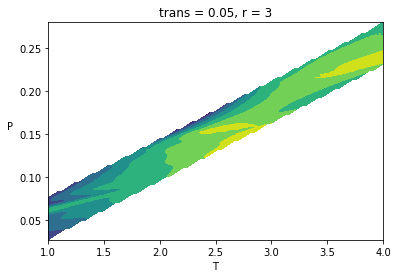

In [29]:
T = np.array([1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4])
P = np.array([0.05736717,0.12473434,0.19210152,0.25946869,0.06236717,0.12973434,0.19710152,0.26446869,0.06736717,0.13473434,0.20210152,0.26946869,0.07236717,0.13973434,0.20710152,0.27446869,0.07736717,0.14473434,0.21210152,0.27946869,0.04736717167910913,0.11473434335821826,0.18210151503732741,0.24946868671643654,0.037367171679109135,0.10473434335821827,0.1721015150373274,0.23946868671643654,0.027367171679109133,0.094734343358218259,0.16210151503732739,0.22946868671643653])
C = np.array([0.20901875,0.29107216,0.3037613,0.32117151,0.28128912,0.29050201,0.29816884,0.29965524,0.12731773,0.26513234,0.28540928,0.29925197,0.14468187,0.24243838,0.28029671,0.27945095,0.10775884,0.1144538,0.2743782,0.27575066,0.18560167379858603,0.29391416992579078,0.31368730509565007,0.33351011808696568,0.1487745221539484,0.28485199999801253,0.30699843259932064,0.38863033843126926,0.10555179114639045,0.29859453061044805,0.35266736755924288,0.31959852418113938])



p = np.column_stack((T,P))




xi = np.linspace(T.min(), T.max(), 100)
yi = np.linspace(P.min(), P.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# interpolate
zi = griddata(p, C, (xi, yi), method="cubic")

plt.contourf(xi, yi, zi)

plt.title('trans = 0.05, r = 3')


h = plt.ylabel('P   ')
h.set_rotation(0)
plt.xlabel('T')


plt.savefig("contour.png")

In [ ]:
Old_C
Old_P
Old_T


In [ ]:
T = [1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4]

P = [ 0.05736717  0.12473434  0.19210152  0.25946869  0.06236717  0.12973434
  0.19710152  0.26446869  0.06736717  0.13473434  0.20210152  0.26946869
  0.07236717  0.13973434  0.20710152  0.27446869  0.07736717  0.14473434
  0.21210152  0.27946869 0.04736717167910913 0.11473434335821826 0.18210151503732741 0.24946868671643654 0.037367171679109135 0.10473434335821827 0.1721015150373274 0.23946868671643654]


C = [ 0.20901875  0.29107216  0.3037613   0.32117151  0.28128912  0.29050201
  0.29816884  0.29965524  0.12731773  0.26513234  0.28540928  0.29925197
  0.14468187  0.24243838  0.28029671  0.27945095  0.10775884  0.1144538
  0.2743782   0.27575066 0.18560167379858603 0.29391416992579078 0.31368730509565007 0.33351011808696568 0.1487745221539484 0.28485199999801253 0.30699843259932064 0.38863033843126926]



SAVING ACTIVITY TO: feb27/207b95b5858a1a31cf19.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.04736717167910913, 'lgn_r': 3, 'lgn_t': 1, 'lgn_a': 0.05, 'corr': 0.18560167379858603, 'time': 'Wed, 28 Feb 2018 18:39:37 GMT', 'id': '207b95b5858a1a31cf19'}
SAVING ACTIVITY TO: feb27/aa1af5783d307c443a41.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.11473434335821826, 'lgn_r': 3, 'lgn_t': 2, 'lgn_a': 0.05, 'corr': 0.29391416992579078, 'time': 'Wed, 28 Feb 2018 19:12:57 GMT', 'id': 'aa1af5783d307c443a41'}
SAVING ACTIVITY TO: feb27/0bed2e8f1a6302b0f4c4.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.18210151503732741, 'lgn_r': 3, 'lgn_t': 3, 'lgn_a': 0.05, 'corr': 0.31368730509565007, 'time': 'Wed, 28 Feb 2018 19:34:03 GMT', 'id': '0bed2e8f1a6302b0f4c4'}
SAVING ACTIVITY TO: feb27/28f77ccd4f94880ab45b.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.24946868671643654, 'lgn_r': 3, 'lgn_t': 4, 'lgn_a': 0.05, 'corr': 0.33351011808696568, 'time': 'Wed, 28 Feb 2018 19:54:57 GMT', 'id': '28f77ccd4f94880ab45b'}

SAVING ACTIVITY TO: feb27/b0c3345b3fa3eecc3824.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.037367171679109135, 'lgn_r': 3, 'lgn_t': 1, 'lgn_a': 0.05, 'corr': 0.1487745221539484, 'time': 'Wed, 28 Feb 2018 22:53:57 GMT', 'id': 'b0c3345b3fa3eecc3824'}
SAVING ACTIVITY TO: feb27/2b71761de1abf5e59c6e.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.10473434335821827, 'lgn_r': 3, 'lgn_t': 2, 'lgn_a': 0.05, 'corr': 0.28485199999801253, 'time': 'Wed, 28 Feb 2018 23:14:50 GMT', 'id': '2b71761de1abf5e59c6e'}
SAVING ACTIVITY TO: feb27/4a77bc9680eb45fd5a93.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.1721015150373274, 'lgn_r': 3, 'lgn_t': 3, 'lgn_a': 0.05, 'corr': 0.30699843259932064, 'time': 'Wed, 28 Feb 2018 23:35:23 GMT', 'id': '4a77bc9680eb45fd5a93'}
SAVING ACTIVITY TO: feb27/3d3f27681d4266982c7f.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.23946868671643654, 'lgn_r': 3, 'lgn_t': 4, 'lgn_a': 0.05, 'corr': 0.38863033843126926, 'time': 'Wed, 28 Feb 2018 23:55:50 GMT', 'id': '3d3f27681d4266982c7f'}

SAVING ACTIVITY TO: feb27/10dc163bb54b771cd996.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.027367171679109133, 'lgn_r': 3, 'lgn_t': 1, 'lgn_a': 0.05, 'corr': 0.10555179114639045, 'time': 'Thu, 01 Mar 2018 01:13:21 GMT', 'id': '10dc163bb54b771cd996'}
SAVING ACTIVITY TO: feb27/2d9a8a7285b3183ef27a.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.094734343358218259, 'lgn_r': 3, 'lgn_t': 2, 'lgn_a': 0.05, 'corr': 0.29859453061044805, 'time': 'Thu, 01 Mar 2018 01:34:13 GMT', 'id': '2d9a8a7285b3183ef27a'}
SAVING ACTIVITY TO: feb27/628e5234094e016a2e83.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.16210151503732739, 'lgn_r': 3, 'lgn_t': 3, 'lgn_a': 0.05, 'corr': 0.35266736755924288, 'time': 'Thu, 01 Mar 2018 01:54:45 GMT', 'id': '628e5234094e016a2e83'}
SAVING ACTIVITY TO: feb27/c86c3928f94fdb4ba12b.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.22946868671643653, 'lgn_r': 3, 'lgn_t': 4, 'lgn_a': 0.05, 'corr': 0.31959852418113938, 'time': 'Thu, 01 Mar 2018 02:14:44 GMT', 'id': 'c86c3928f94fdb4ba12b'}
SAVING ACTIVITY TO: feb27/74838082fb46b2740620.png


T = np.array([1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4])
P = np.array([0.05736717,0.12473434,0.19210152,0.25946869,0.06236717,0.12973434,0.19710152,0.26446869,0.06736717,0.13473434,0.20210152,0.26946869,0.07236717,0.13973434,0.20710152,0.27446869,0.07736717,0.14473434,0.21210152,0.27946869,0.04736717167910913,0.11473434335821826,0.18210151503732741,0.24946868671643654,0.037367171679109135,0.10473434335821827,0.1721015150373274,0.23946868671643654])
C = np.array([0.20901875,0.29107216,0.3037613,0.32117151,0.28128912,0.29050201,0.29816884,0.29965524,0.12731773,0.26513234,0.28540928,0.29925197,0.14468187,0.24243838,0.28029671,0.27945095,0.10775884,0.1144538,0.2743782,0.27575066,0.18560167379858603,0.29391416992579078,0.31368730509565007,0.33351011808696568,0.1487745221539484,0.28485199999801253,0.30699843259932064,0.38863033843126926])



T = np.array([1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4])
P = np.array([0.05736717,0.12473434,0.19210152,0.25946869,0.06236717,0.12973434,0.19710152,0.26446869,0.06736717,0.13473434,0.20210152,0.26946869,0.07236717,0.13973434,0.20710152,0.27446869,0.07736717,0.14473434,0.21210152,0.27946869,0.04736717167910913,0.11473434335821826,0.18210151503732741,0.24946868671643654,0.037367171679109135,0.10473434335821827,0.1721015150373274,0.23946868671643654,0.027367171679109133,0.094734343358218259,0.16210151503732739,0.22946868671643653])
C = np.array([0.20901875,0.29107216,0.3037613,0.32117151,0.28128912,0.29050201,0.29816884,0.29965524,0.12731773,0.26513234,0.28540928,0.29925197,0.14468187,0.24243838,0.28029671,0.27945095,0.10775884,0.1144538,0.2743782,0.27575066,0.18560167379858603,0.29391416992579078,0.31368730509565007,0.33351011808696568,0.1487745221539484,0.28485199999801253,0.30699843259932064,0.38863033843126926,0.10555179114639045,0.29859453061044805,0.35266736755924288,0.31959852418113938])



In [ ]:
SAVING ACTIVITY TO: feb23_2018/8144dcb0b8e3b1a81b2a.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.13473434335821827, 'lgn_r': 3, 'lgn_t': 2, 'lgn_a': 0.05, 'corr': 0.27331283620845676, 'time': 'Tue, 27 Feb 2018 23:40:43 GMT', 'id': '8144dcb0b8e3b1a81b2a'}
SAVING ACTIVITY TO: feb23_2018/d568dc471e40b6b0b675.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.13473434335821827, 'lgn_r': 3, 'lgn_t': 2, 'lgn_a': 0.05, 'corr': 0.26599147637795101, 'time': 'Wed, 28 Feb 2018 00:03:59 GMT', 'id': 'd568dc471e40b6b0b675'}
SAVING ACTIVITY TO: feb23_2018/27c9d96d657d23c0ba7a.png
{'num_filters': 2000, 'num_components': 20, 'num_patches': 100000, 'patch_size': 8, 'lgn_width': 64, 'lgn_p': 0.13473434335821827, 'lgn_r': 3, 'lgn_t': 2, 'lgn_a': 0.05, 'corr': 0.27595317580808237, 'time': 'Wed, 28 Feb 2018 00:26:52 GMT', 'id': '27c9d96d657d23c0ba7a'}